In [1]:
%run -m ipy_startup
%run -m ipy_logging false
%run -m ipy_seaborn
%matplotlib inline
from mgds.data_aggregation import database as db
from mgds.data_aggregation import source as src
from mgds.data_aggregation import data_type as dtyp
from mgds.data_modeling import data_broker as dbm
from ml.api import trainer as ml_trainer
import tensorflow as tf
import tensorflow.contrib.learn.python.learn as learn

In [3]:
# Load data from data_modeling/prep/tcga-prep.ipynb
d = db.load_obj(src.TCGA_v1, db.PREP, 'raw-data-matrices')
d.keys()

dict_keys(['gene-copy-number', 'gene-exome-seq', 'gene-expression', 'gene-methylation', 'gene-rppa', 'gene-rna-seq'])

In [4]:
cohort = 'brca'

In [5]:
def prep(df, dt):
    df = df.loc[cohort]
    df.columns = pd.MultiIndex.from_tuples([(dt, c) for c in df])
    return df
df = pd.concat([prep(df, dt) for dt, df in d.items()], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1105 entries, TCGA-3C-AAAU-01 to TCGA-Z7-A8R6-01
Columns: 90637 entries, (gene-copy-number, A1BG) to (gene-rna-seq, ZZZ3)
dtypes: float64(90637)
memory usage: 764.1+ MB


In [6]:
df.head()

gene-copy-number                                             \
                            A1BG A1CF  A2M A2ML1 A2MP1 A3GALT2 A4GALT A4GNT   
TCGA-3C-AAAU-01              0.0 -1.0  1.0   1.0   1.0     0.0   -1.0   1.0   
TCGA-3C-AALI-01              0.0 -1.0  0.0   0.0   0.0    -1.0   -1.0   1.0   
TCGA-3C-AALJ-01              0.0  0.0  0.0   0.0   0.0    -1.0   -1.0  -1.0   
TCGA-3C-AALK-01              0.0  0.0  0.0   0.0   0.0     0.0    0.0   0.0   
TCGA-4H-AAAK-01              1.0  0.0 -1.0  -1.0  -1.0     0.0    0.0   0.0   

                            ...   gene-rna-seq                          \
                AAAS AACS   ...         ZWILCH   ZWINT    ZXDA    ZXDB   
TCGA-3C-AAAU-01 -1.0 -1.0   ...        -0.1875  0.2566  2.5022  1.4301   
TCGA-3C-AALI-01  0.0  0.0   ...         3.8487  0.3196 -0.1816 -0.4114   
TCGA-3C-AALJ-01 -1.0  1.0   ...        -0.7852  3.2911 -1.1222 -0.1302   
TCGA-3C-AALK-01  0.0  0.0   ...        -0.3029 -0.2431 -0.3657 -0.4472   
TCGA-4H-AAAK-01  0.0  0.0   ...        -0.2423 -0.2320 -0.6000 -0.4916   

                                                                 
                   ZXDC  ZYG11A  ZYG11B     ZYX   ZZEF1    ZZZ3  
TCGA-3C-AAAU-01  2.4849  1.7280  1.1117 -0.1441  0.8941  0.3312  
TCGA-3C-AALI-01  1.0797  1.0743 -1.0477  0.9689 -0.3256 -1.1244  
TCGA-3C-AALJ-01 -1.4793  2.5267 -1.3026  0.9433 -1.1210 -0.9310  
TCGA-3C-AALK-01 -1.0557  0.8232 -1.0342  1.0729 -1.4634 -0.5710  
TCGA-4H-AAAK-01 -0.2273 -0.9346 -0.4330  0.1537 -1.3559 -0.2308  

[5 rows x 90637 columns]

In [7]:
len(df)

1105

In [289]:
#feature_typ = dtyp.GENE_RNA_SEQ
feature_typ = dtyp.GENE_EXPRESSION
X = df[[feature_typ, dtyp.GENE_RPPA]].dropna(how='all', axis=1).dropna(how='all', axis=0)
m1 = X[feature_typ].isnull().all(axis=1)
m2 = X[dtyp.GENE_RPPA].isnull().all(axis=1)
X = X[(~m1) & (~m2)]
X, Y = X[feature_typ], X[dtyp.GENE_RPPA]
Y = Y.iloc[:,:10]
X = X.iloc[:,:]

In [290]:
X.shape, Y.shape

((403, 16810), (403, 10))

In [291]:
Y.columns.tolist()

['ABL1',
 'ACACA',
 'ACVRL1',
 'ADAR',
 'AKT1',
 'AKT2',
 'AKT3',
 'ANXA1',
 'ANXA7',
 'AR']

In [292]:
# import imp
# imp.reload(ml_tf)

In [293]:
# Good performance for 1000 features, 10 outputs
# Also decent for 10000 features, but training takes 

# from ml.tensorflow import tflearn as ml_tf
# from ml.tensorflow import utilities as tf_utils
# from tensorflow.python.ops import logging_ops

# model_dir = '/tmp/tf/rppa_model1/'
# !rm -rf /tmp/tf/rppa_model1/*
# import pdb

# def tf_model_fn(features, targets, mode, params):
    
#     # Connect the first hidden layer to input layer
#     # (features) with relu activation
#     weight_regularizer = tf.contrib.layers.regularizers.l2_regularizer(params['weight'])
#     bias_regularizer = tf.contrib.layers.regularizers.l2_regularizer(params['bias'])
    
#     first_layer = tf.contrib.layers.linear(
#         features, len(Y.columns), 
#         weights_regularizer=weight_regularizer,
#         weights_initializer=tf.contrib.layers.init_ops.zeros_initializer,#tf.contrib.layers.initializers.variance_scaling_initializer(),
#         biases_regularizer=bias_regularizer,
#         biases_initializer=tf.contrib.layers.init_ops.zeros_initializer,
#         variables_collections=['first_layer']
#     )

#     # first_hidden_layer = tf.contrib.layers.dropout(first_hidden_layer)
#     first_layer_vars = tf.get_collection('first_layer')
#     tf.summary.histogram('first_layer', first_layer)
#     tf.summary.histogram('first_layer_w', first_layer_vars[0])
#     tf.summary.histogram('first_layer_b', first_layer_vars[1])

#     predictions = first_layer
    
#     def get_min_max(v):
#         v = pd.DataFrame(v)
#         return [v.min().min(), v.max().max()]
#     predictions_dict = {"values": predictions}
    
#     if mode == learn.ModeKeys.INFER:
#         return predictions_dict, None, None

#     mse = tf.contrib.losses.mean_squared_error(predictions, targets)
#     print('Mse: ', mse)
#     tf.summary.scalar('mse', mse)
    
#     reg = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
#     if len(reg) > 0:
#         reg = tf.add_n(reg)
#         tf.summary.scalar('reg', reg)
#         loss = mse + tf.cast(reg, tf.float32)
#     else:
#         loss = mse

#     train_op = tf.contrib.layers.optimize_loss(
#         loss=loss,
#         global_step=tf.contrib.framework.get_global_step(),
#         learning_rate=params["learning_rate"],
#         optimizer="Adam",
#         clip_gradients=1.
#     )

#     return predictions_dict, loss, train_op

# model_params = {'learning_rate': .001, 'n_hidden': [10], 'weight': 25., 'bias': 1.}

# steps = 200
# run_config = learn.RunConfig(
#     gpu_memory_fraction=.8, save_summary_steps=steps//10, 
#     save_checkpoints_steps=steps//10, save_checkpoints_secs=None,
#     keep_checkpoint_max=10
# )
# run_config.tf_config.gpu_options.allocator_type = 'BFC'
# tf_clf1 = ml_tf.LearnRegressor(
#     model_fn=tf_model_fn, 
#     model_params=model_params, 
#     fit_params={'max_steps': steps, 'batch_size': None}, 
#     model_dir = model_dir,
#     prediction_output='values',
#     model_config=run_config
# )

In [294]:
from ml.tensorflow import tflearn as ml_tf
from ml.tensorflow import utilities as tf_utils
from tensorflow.python.ops import logging_ops

model_dir = '/tmp/tf/rppa_model1/'
!rm -rf /tmp/tf/rppa_model1/*
import pdb

def tf_model_fn(features, targets, mode, params):
    
    # Connect the first hidden layer to input layer
    # (features) with relu activation
    weight_regularizer = tf.contrib.layers.regularizers.l2_regularizer(params['weight'])
    bias_regularizer = tf.contrib.layers.regularizers.l2_regularizer(params['bias'])
    
    first_layer = tf.contrib.layers.linear(
        features, len(Y.columns), 
        weights_regularizer=weight_regularizer,
        weights_initializer=tf.contrib.layers.init_ops.zeros_initializer,#tf.contrib.layers.initializers.variance_scaling_initializer(),
        biases_regularizer=bias_regularizer,
        biases_initializer=tf.contrib.layers.init_ops.zeros_initializer,
        variables_collections=['first_layer']
    )

    # first_hidden_layer = tf.contrib.layers.dropout(first_hidden_layer)
    first_layer_vars = tf.get_collection('first_layer')
    tf.summary.histogram('first_layer', first_layer)
    tf.summary.histogram('first_layer_w', first_layer_vars[0])
    tf.summary.histogram('first_layer_b', first_layer_vars[1])

    predictions = first_layer
    
    def get_min_max(v):
        v = pd.DataFrame(v)
        return [v.min().min(), v.max().max()]
    predictions_dict = {"values": predictions}
    
    if mode == learn.ModeKeys.INFER:
        return predictions_dict, None, None

    mse = tf.contrib.losses.mean_squared_error(predictions, targets)
    print('Mse: ', mse)
    tf.summary.scalar('mse', mse)
    
    reg = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    if len(reg) > 0:
        reg = tf.add_n(reg)
        tf.summary.scalar('reg', reg)
        loss = mse + tf.cast(reg, tf.float32)
    else:
        loss = mse

    train_op = tf.contrib.layers.optimize_loss(
        loss=loss,
        global_step=tf.contrib.framework.get_global_step(),
        learning_rate=params["learning_rate"],
        optimizer="Adam",
        clip_gradients=1.
    )

    return predictions_dict, loss, train_op

model_params = {'learning_rate': .001, 'n_hidden': [10], 'weight': 25., 'bias': 0.}

steps = 200
run_config = learn.RunConfig(
    gpu_memory_fraction=.8, save_summary_steps=steps//10, 
    save_checkpoints_steps=steps//10, save_checkpoints_secs=None,
    keep_checkpoint_max=10
)
run_config.tf_config.gpu_options.allocator_type = 'BFC'
tf_clf1 = ml_tf.LearnRegressor(
    model_fn=tf_model_fn, 
    model_params=model_params, 
    fit_params={'max_steps': steps, 'batch_size': None}, 
    model_dir = model_dir,
    prediction_output='values',
    model_config=run_config
)

In [295]:
# model_dir = '/tmp/tf/rppa_model2/'
# !rm -rf /tmp/tf/rppa_model2/*

# def monitor_fn(X, y): 
#     return {'loss': learn.monitors.CaptureVariable('global_step')}

# tf_clf2 = ml_tf.LearnRegressor(
#     model_fn=lambda model_dir: learn.DNNRegressor(
#         hidden_units=[10], 
#         #dropout=.5,
#         feature_columns=learn.infer_real_valued_columns_from_input(X), 
#         optimizer=tf.train.GradientDescentOptimizer(.001),
#         model_dir=model_dir,
#         label_dimension=Y.shape[1],
#         config=learn.RunConfig(
#             gpu_memory_fraction=.5, save_summary_steps=30, 
#             save_checkpoints_steps=30, save_checkpoints_secs=None,
#             keep_checkpoint_max=10
#         )
#     ),
#     model_dir=model_dir,
#     fit_params={'max_steps': 300, 'monitor_fn': monitor_fn},
# )

In [296]:
from sklearn.neighbors import KNeighborsRegressor

In [308]:
#%%time
from mgds.data_modeling.constants import SEED
from sklearn.linear_model import MultiTaskLasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, RobustScaler
from IPython.core.debugger import Tracer

clfs = {
#     'lasso': Pipeline([
#         ('imp', Imputer(strategy='median')),
#         ('scale', RobustScaler()),
#         ('clf', MultiTaskLasso(random_state=SEED))
#     ]),
    'knn': Pipeline([
        ('imp', Imputer(strategy='median')),
        ('scale', RobustScaler()),
        ('clf', KNeighborsRegressor(n_neighbors=10, weights='distance', p=2))
    ]),
    
#     'rf': Pipeline([
#         ('imp', Imputer(strategy='median')),
#         ('clf', RandomForestRegressor(random_state=SEED))
#     ]),
#     'tf_dnn1': Pipeline([
#         ('imp', Imputer(strategy='median')),
#         ('scale', RobustScaler()),
#         ('clf', tf_clf1)
#     ]),
    'baseline': Pipeline([
        ('imp', Imputer(strategy='median')),
        ('clf', DummyRegressor())
    ]),
#     'tf_dnn2': Pipeline([
#         ('imp', Imputer(strategy='median')),
#         ('scale', RobustScaler()),
#         ('clf', tf_clf2)
#     ])
}
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
    
def data_prep_fn(X_train, X_test, Y_train, Y_test):
    imp = Imputer(strategy='median').fit(Y_train)
    Y_train = pd.DataFrame(imp.transform(Y_train), columns=Y_train.columns, index=Y_train.index)
    Y_test = pd.DataFrame(imp.transform(Y_test), columns=Y_test.columns, index=Y_test.index)
    return X_train, X_test, Y_train, Y_test

def model_fit_fn(clf_name, clf, X_train, Y_train, X_test, Y_test, fold):
    if not clf_name.startswith('tf_'):
        clf.fit(X_train, Y_train)
    clf.fit(X_train.values, Y_train.values)

config = ml_trainer.TrainerConfig(
    data_prep_fn=data_prep_fn,
    model_fit_fn=model_fit_fn,
    keep_test_data=True
)

tf.logging.set_verbosity(tf.logging.ERROR)
trainer = ml_trainer.Trainer()
train_res = trainer.train_regressors(X, Y, clfs, cv.split(X), config=config)

2017-01-07 19:44:24,340:INFO:ml.model.log: Running model baseline (Pipeline) on fold 1 ==> dim(X_train) = (322, 16810), dim(X_test) = (81, 16810), dim(Y_train) = (322, 10), dim(Y_test) = (81, 10)


Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-01-07 19:44:25,483:INFO:ml.model.log: Running model knn (Pipeline) on fold 1 ==> dim(X_train) = (322, 16810), dim(X_test) = (81, 16810), dim(Y_train) = (322, 10), dim(Y_test) = (81, 10)
2017-01-07 19:44:27,939:INFO:ml.model.log: Running model baseline (Pipeline) on fold 2 ==> dim(X_train) = (322, 16810), dim(X_test) = (81, 16810), dim(Y_train) = (322, 10), dim(Y_test) = (81, 10)
2017-01-07 19:44:29,011:INFO:ml.model.log: Running model knn (Pipeline) on fold 2 ==> dim(X_train) = (322, 16810), dim(X_test) = (81, 16810), dim(Y_train) = (322, 10), dim(Y_test) = (81, 10)
2017-01-07 19:44:31,452:INFO:ml.model.log: Running model baseline (Pipeline) on fold 3 ==> dim(X_train) = (322, 16810), dim(X_test) = (81, 16810), dim(Y_train) = (322, 10), dim(Y_test) = (81, 10)
2017-01-07 19:44:32,523:INFO:ml.model.log: Running model knn (Pipeline) on fold 3 ==> dim(X_train) = (322, 16810), dim(X_test) = (81, 16810), dim(Y_train) = (322, 10), dim(Y_test) = (81, 10)
2017-01-07 19:44:34,999:INFO:ml.mod

Beginning model refitting


2017-01-07 19:44:43,676:INFO:ml.model.log: Running model knn (Pipeline) on fold 0 ==> dim(X_train) = (403, 16810), dim(X_test) = (403, 16810), dim(Y_train) = (403, 10), dim(Y_test) = (403, 10)
2017-01-07 19:44:49,563:INFO:ml.model.log: Model refitting complete (2 model(s) run)
2017-01-07 19:44:49,563:INFO:ml.model.log: --------------------------------------------------------------------------------


In [309]:
train_res.save(dbm.file('rppa', 'train_res'))
#train_res = ml_trainer.TrainingResult.load(dbm.file('rppa', 'train_res'))

2017-01-07 19:59:05,874:DEBUG:py_utils.io_utils: Serializing object ""CV Training Result" to" to location "/Users/eczech/data/research/mgds/modeling/rppa/train_res.pkl"


In [310]:
from ml.api.results import predictions
import imp
imp.reload(predictions)

<module 'ml.api.results.predictions' from '/Users/eczech/repos/portfolio/functional/ml/python/ml/api/results/predictions.py'>

In [311]:
d_pred = predictions.extract(train_res)

In [312]:
d_pred.head()

Category        Features                                                  \
Task                A1BG     A2M   A2ML1 A3GALT2  A4GALT   A4GNT    AAAS   
TCGA-A1-A0SO-01   2.2930 -1.6865 -0.0321 -1.2594 -2.0328 -0.4425 -0.4925   
TCGA-A2-A04N-01  -0.0911 -0.4117  0.0852  0.6102 -1.1284 -0.3005 -0.4070   
TCGA-A2-A04T-01  -0.3762 -0.1134  5.1844  0.9436 -1.2175 -0.4495 -1.1449   
TCGA-A2-A04U-01   0.8947  2.0636  1.3438  0.5185 -0.1630  0.6473  0.2882   
TCGA-A2-A04V-01   0.4970 -0.5719  0.3869 -0.9602 -0.4616 -0.6606  1.3611   

Category                                       ...          \
Task               AACS   AADAC AADACL2        ...           
TCGA-A1-A0SO-01 -1.4713 -0.0874 -0.2195        ...           
TCGA-A2-A04N-01 -1.2695 -0.3801 -0.1100        ...           
TCGA-A2-A04T-01 -2.1525 -0.4933  0.2686        ...           
TCGA-A2-A04U-01 -3.3190  0.4097 -0.7810        ...           
TCGA-A2-A04V-01 -1.3635  2.1664 -0.1366        ...           

Category                 Predictions                        \
Task            Value:Predicted:ABL1 Value:Predicted:ACACA   
TCGA-A1-A0SO-01             0.103616              0.200457   
TCGA-A2-A04N-01             0.103616              0.200457   
TCGA-A2-A04T-01             0.103616              0.200457   
TCGA-A2-A04U-01             0.103616              0.200457   
TCGA-A2-A04V-01             0.103616              0.200457   

Category                                                     \
Task            Value:Predicted:ACVRL1 Value:Predicted:ADAR   
TCGA-A1-A0SO-01              -0.036097             0.199937   
TCGA-A2-A04N-01              -0.036097             0.199937   
TCGA-A2-A04T-01              -0.036097             0.199937   
TCGA-A2-A04U-01              -0.036097             0.199937   
TCGA-A2-A04V-01              -0.036097             0.199937   

Category                                                   \
Task            Value:Predicted:AKT1 Value:Predicted:AKT2   
TCGA-A1-A0SO-01             0.012883             0.012883   
TCGA-A2-A04N-01             0.012883             0.012883   
TCGA-A2-A04T-01             0.012883             0.012883   
TCGA-A2-A04U-01             0.012883             0.012883   
TCGA-A2-A04V-01             0.012883             0.012883   

Category                                                    \
Task            Value:Predicted:AKT3 Value:Predicted:ANXA1   
TCGA-A1-A0SO-01             0.012883             -0.138899   
TCGA-A2-A04N-01             0.012883             -0.138899   
TCGA-A2-A04T-01             0.012883             -0.138899   
TCGA-A2-A04U-01             0.012883             -0.138899   
TCGA-A2-A04V-01             0.012883             -0.138899   

Category                                                  
Task            Value:Predicted:ANXA7 Value:Predicted:AR  
TCGA-A1-A0SO-01             -0.025922          -0.001681  
TCGA-A2-A04N-01             -0.025922          -0.001681  
TCGA-A2-A04T-01             -0.025922          -0.001681  
TCGA-A2-A04U-01             -0.025922          -0.001681  
TCGA-A2-A04V-01             -0.025922          -0.001681  

[5 rows x 16832 columns]

In [313]:
from ml.api.results import performance, properties
imp.reload(properties)

<module 'ml.api.results.properties' from '/Users/eczech/repos/portfolio/functional/ml/python/ml/api/results/properties.py'>

In [314]:
from ml.api.results import performance
from sklearn.metrics import r2_score

score_fn = lambda y_true, y_pred: {
    'r2': r2_score(y_true, y_pred), 
    'pearson2': y_true.corr(y_pred, method='pearson')**2,
    'spearman2': y_true.corr(y_pred, method='spearman')**2
}
d_score = performance.compute_scores(train_res, score_fn, predictions=d_pred)
d_score

Metric             pearson2                                            \
Task                   ABL1         ACACA        ACVRL1          ADAR   
Model    Fold                                                           
baseline 1     1.757556e-33           NaN  9.027662e-34  9.774583e-34   
         2     2.032711e-33           NaN  1.751057e-35           NaN   
         3              NaN  1.170027e-33  9.924755e-34  1.642493e-33   
         4     2.562521e-34           NaN  0.000000e+00           NaN   
         5     8.899453e-35  9.741379e-33  0.000000e+00  0.000000e+00   
knn      1     2.347458e-03  8.101980e-02  4.717593e-02  1.248506e-01   
         2     2.807550e-03  9.921286e-02  9.671147e-03  2.703364e-01   
         3     1.155553e-06  4.502384e-02  6.670334e-02  1.745290e-01   
         4     1.242784e-03  9.139367e-02  5.452990e-03  1.629923e-01   
         5     2.215732e-03  1.198862e-01  2.477108e-02  1.499331e-01   

Metric                                                                 \
Task                   AKT1          AKT2          AKT3         ANXA1   
Model    Fold                                                           
baseline 1     9.667587e-35  9.667587e-35  9.667587e-35           NaN   
         2     2.371621e-34  2.371621e-34  2.371621e-34  4.732891e-34   
         3     1.150190e-34  1.150190e-34  1.150190e-34  8.596795e-34   
         4     3.957696e-34  3.957696e-34  3.957696e-34  7.347919e-34   
         5              NaN           NaN           NaN  2.584817e-34   
knn      1     8.822565e-02  8.822565e-02  8.822565e-02  1.546897e-01   
         2     1.133019e-01  1.133019e-01  1.133019e-01  1.203766e-01   
         3     8.814406e-02  8.814406e-02  8.814406e-02  3.989922e-01   
         4     3.901419e-02  3.901419e-02  3.901419e-02  7.936790e-02   
         5     5.897243e-02  5.897243e-02  5.897243e-02  2.009978e-01   

Metric                                       ...    spearman2            \
Task                  ANXA7            AR    ...         ABL1     ACACA   
Model    Fold                                ...                          
baseline 1     1.034998e-34  8.489423e-34    ...          NaN       NaN   
         2     2.160747e-34           NaN    ...          NaN       NaN   
         3     9.040224e-35  6.151728e-34    ...          NaN       NaN   
         4              NaN  1.134558e-34    ...          NaN       NaN   
         5     4.869113e-34  2.071742e-34    ...          NaN       NaN   
knn      1     8.186603e-02  5.227925e-01    ...     0.000420  0.084859   
         2     1.932674e-01  3.929739e-01    ...     0.015994  0.104805   
         3     1.725084e-02  4.674913e-01    ...     0.000472  0.020962   
         4     1.709979e-01  5.376224e-01    ...     0.000274  0.093107   
         5     2.929081e-02  2.901960e-01    ...     0.000965  0.143496   

Metric                                                                     \
Task             ACVRL1      ADAR      AKT1      AKT2      AKT3     ANXA1   
Model    Fold                                                               
baseline 1          NaN       NaN       NaN       NaN       NaN       NaN   
         2          NaN       NaN       NaN       NaN       NaN       NaN   
         3          NaN       NaN       NaN       NaN       NaN       NaN   
         4          NaN       NaN       NaN       NaN       NaN       NaN   
         5          NaN       NaN       NaN       NaN       NaN       NaN   
knn      1     0.030121  0.124803  0.142887  0.142887  0.142887  0.180241   
         2     0.008877  0.254104  0.164310  0.164310  0.164310  0.192425   
         3     0.042132  0.158180  0.111904  0.111904  0.111904  0.299230   
         4     0.025140  0.172402  0.055015  0.055015  0.055015  0.099448   
         5     0.019716  0.122993  0.043144  0.043144  0.043144  0.213966   

Metric                             
Task              ANXA7        AR  
Model    Fold                      
baseline 1    

In [315]:
imp.reload(performance)

<module 'ml.api.results.performance' from '/Users/eczech/repos/portfolio/functional/ml/python/ml/api/results/performance.py'>

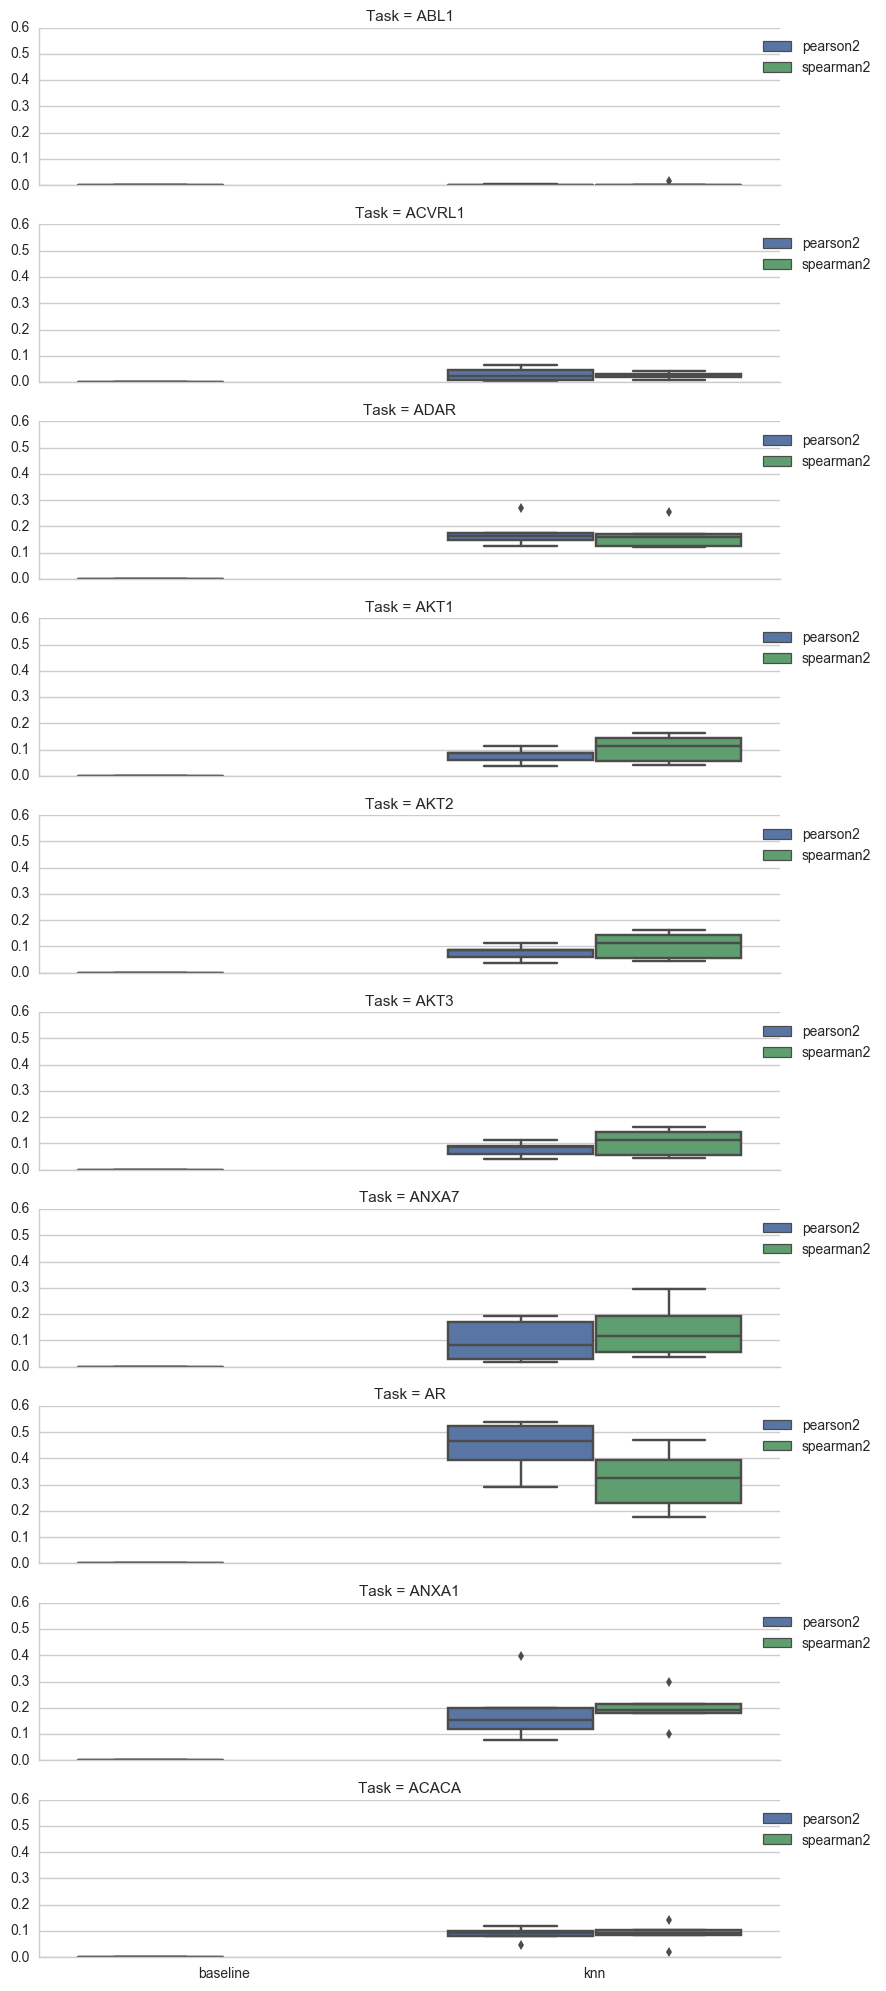

In [316]:
tasks = performance.sample_tasks(d_score, random_state=None, limit=10)
grid, d_viz = performance.plot_scores(d_score, metrics=['pearson2', 'spearman2'], tasks=tasks, figaspect=4, legend_margin=(1.14, 1))

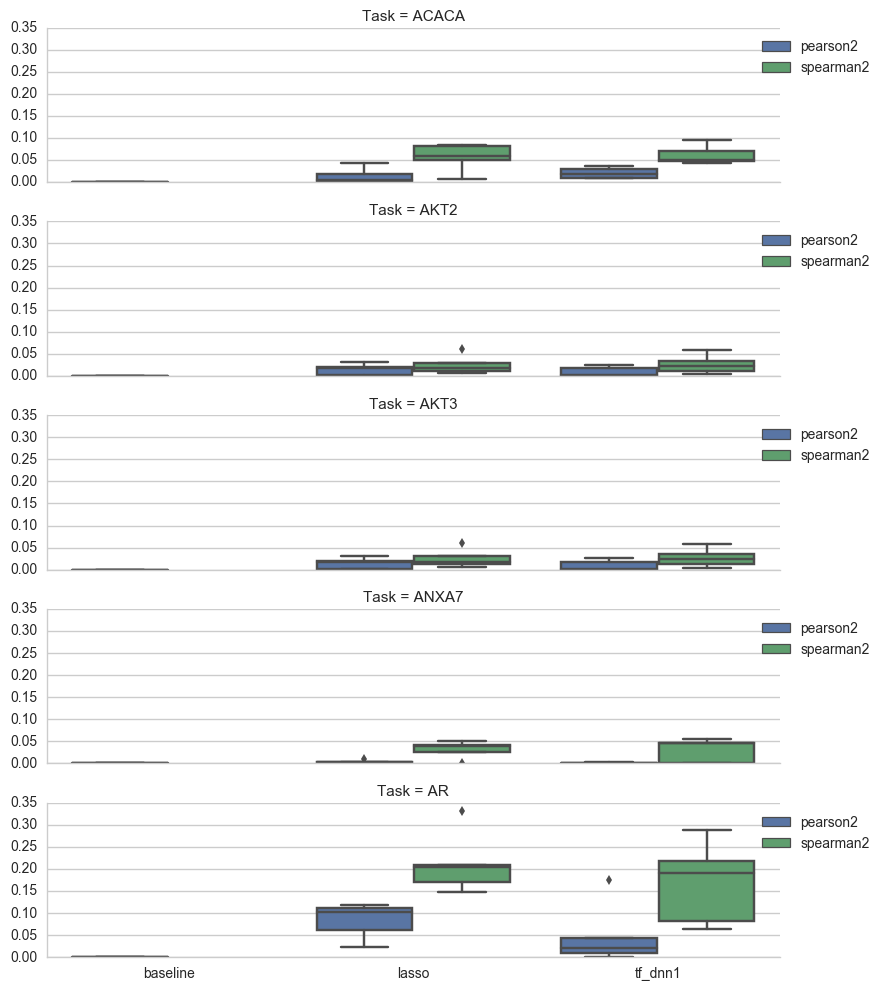

In [219]:
tasks = performance.sample_tasks(d_score, random_state=None, limit=5)
grid, d_viz = performance.plot_scores(d_score, metrics=['pearson2', 'spearman2'], tasks=tasks, figaspect=4, legend_margin=(1.14, 1))

In [286]:
d_pred.head()

Category        Features                                                       \
Task                A1BG A1CF  A2M A2ML1 A2MP1 A3GALT2 A4GALT A4GNT AAAS AACS   
TCGA-A1-A0SJ-01      1.0 -1.0  1.0   1.0   1.0     0.0   -1.0  -1.0 -1.0 -1.0   
TCGA-A2-A04V-01      0.0  0.0  0.0   0.0   0.0     0.0   -1.0   0.0  0.0  0.0   
TCGA-A2-A0CR-01      0.0  0.0  0.0   0.0   0.0     0.0   -1.0   0.0  0.0  0.0   
TCGA-A2-A0CV-01      0.0  0.0  0.0   0.0   0.0     0.0   -1.0   1.0  0.0  0.0   
TCGA-A2-A0D1-01      0.0  0.0  0.0   0.0   0.0     0.0    0.0  -1.0 -1.0 -1.0   

Category               ...                  Predictions                        \
Task                   ...         Value:Predicted:ABL1 Value:Predicted:ACACA   
TCGA-A1-A0SJ-01        ...                     0.001765              0.001785   
TCGA-A2-A04V-01        ...                     0.001765              0.001785   
TCGA-A2-A0CR-01        ...                     0.001765              0.001785   
TCGA-A2-A0CV-01        ...                     0.001765              0.001785   
TCGA-A2-A0D1-01        ...                     0.001765              0.001785   

Category                                                     \
Task            Value:Predicted:ACVRL1 Value:Predicted:ADAR   
TCGA-A1-A0SJ-01               0.014451             0.000767   
TCGA-A2-A04V-01               0.014451             0.000767   
TCGA-A2-A0CR-01               0.014451             0.000767   
TCGA-A2-A0CV-01               0.014451             0.000767   
TCGA-A2-A0D1-01               0.014451             0.000767   

Category                                                   \
Task            Value:Predicted:AKT1 Value:Predicted:AKT2   
TCGA-A1-A0SJ-01             -0.00194             -0.00194   
TCGA-A2-A04V-01             -0.00194             -0.00194   
TCGA-A2-A0CR-01             -0.00194             -0.00194   
TCGA-A2-A0CV-01             -0.00194             -0.00194   
TCGA-A2-A0D1-01             -0.00194             -0.00194   

Category                                                    \
Task            Value:Predicted:AKT3 Value:Predicted:ANXA1   
TCGA-A1-A0SJ-01             -0.00194              0.033394   
TCGA-A2-A04V-01             -0.00194              0.033394   
TCGA-A2-A0CR-01             -0.00194              0.033394   
TCGA-A2-A0CV-01             -0.00194              0.033394   
TCGA-A2-A0D1-01             -0.00194              0.033394   

Category                                                  
Task            Value:Predicted:ANXA7 Value:Predicted:AR  
TCGA-A1-A0SJ-01             -0.006127          -0.036462  
TCGA-A2-A04V-01             -0.006127          -0.036462  
TCGA-A2-A0CR-01             -0.006127          -0.036462  
TCGA-A2-A0CV-01             -0.006127          -0.036462  
TCGA-A2-A0D1-01             -0.006127          -0.036462  

[5 rows x 23304 columns]

In [317]:
imp.reload(predictions)

<module 'ml.api.results.predictions' from '/Users/eczech/repos/portfolio/functional/ml/python/ml/api/results/predictions.py'>

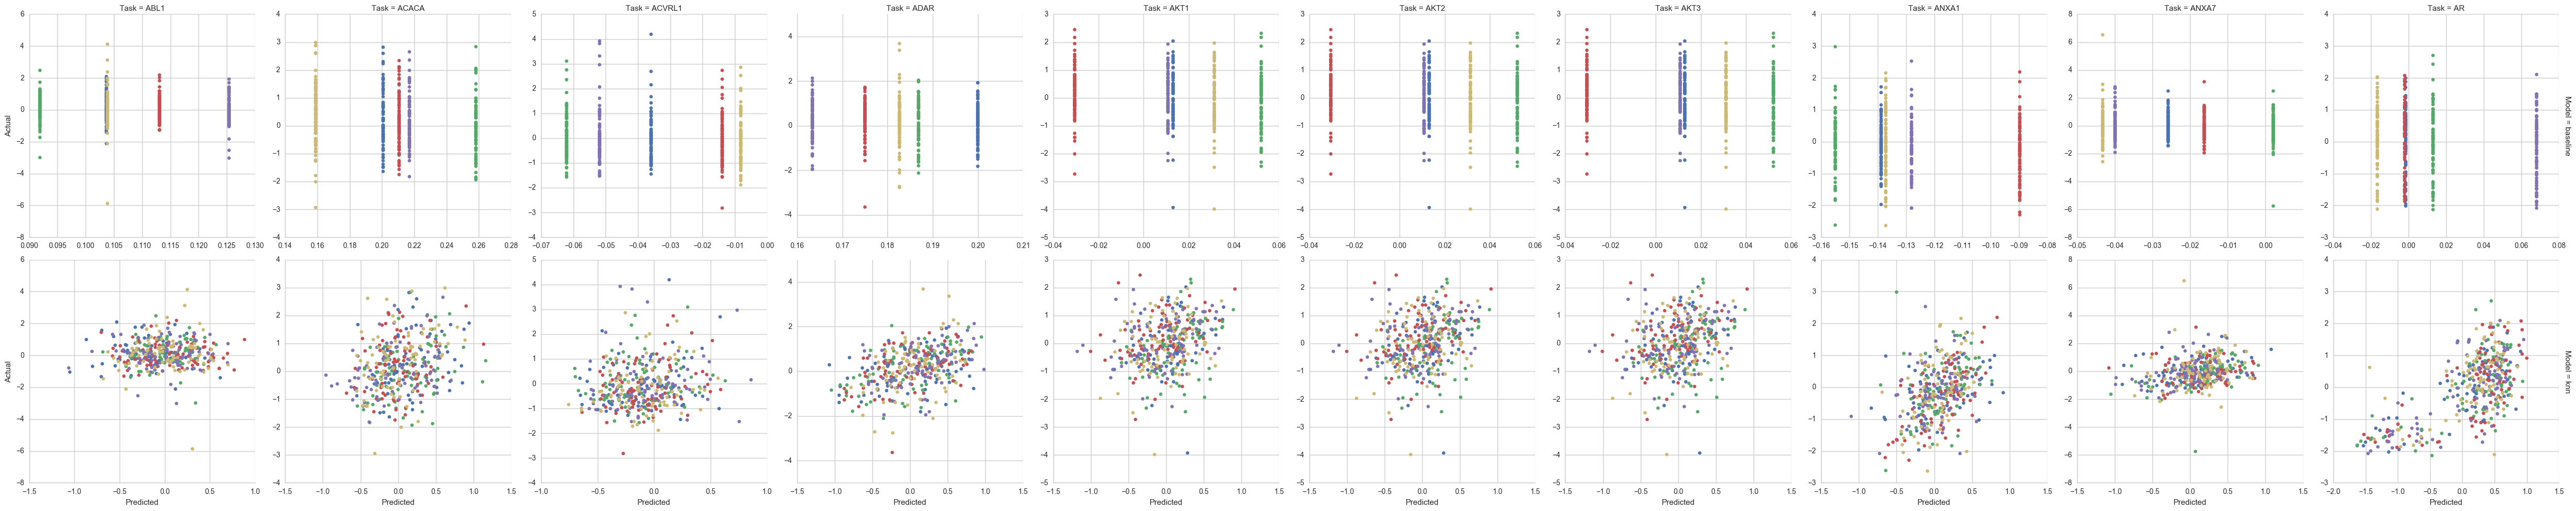

In [318]:
grid, d_viz = predictions.plot_predictions(train_res, d_pred, share_axes=False)